# Dependencies

This is a Python 3 package that relies on the following packages: NumPy, SciPy, Numba, Numexpr. It can be combined with packages like Dask to parallelize propagation jobs. 

# Overview

Lightbeam is a bare-bones beam propagator. This means that the code can be very flexible, but also that you may have to code certain functionalities yourself. The purpose of this notebook is to reveal the different components of the code so you can make use of them. 

There are three main classes of objects that Lightbeam uses.
1. <strong>Mesh</strong> objects, which control the physical size of the simulation zone as well as how that zone is subdivided.
2. <strong>Optics</strong> objects, which encapsulate the geometry and material properties of the waveguide to be simulated.
3. <strong>Propagator</strong> objects, which control parameters regarding the beam propagation algorithm.

We will go over each component in turn. Regarding units, note that the specific choice does not matter. The code only requires that every parameter with a length attached to it is reported in the same units.

## 1. Meshes

### Initialization

In [1]:
from lightbeam import RectMesh3D
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



### Behind the scenes

For the curious ... the RectMesh3D class is primarily a wrapper for the RectMesh2D class, which handles all the adaptive meshing and contains the important class methods. Specifically, the RectMesh3D class stores a RectMesh2D object under the class variable <strong>self.xy</strong>. The type of adaptive mesh implemented here is the simplest, where x and y are subdivided independently. This is a less computationally efficient approach, but maintains 4<sup>th</sup> order accuracy [1]. Resetting the transverse grid to coarse, uniform spacing is handled by <strong>RectMesh2D.reinit()</strong> while grid refinement is handled by <strong>RectMesh2D.refine_base()</strong>. The local degree of refinement required is currently measured from the geometric mean of field amplitude and magnitude of the field's second derivative; I have empirically found this method to work well. The metric by which refinement degree is measured is computed in __RectMesh2D._compute_refinement_factor()__. For more details, see Section 5.

#### Code example

Mesh shape: (5001, 81, 81)
Transverse grid shape: (81, 81)


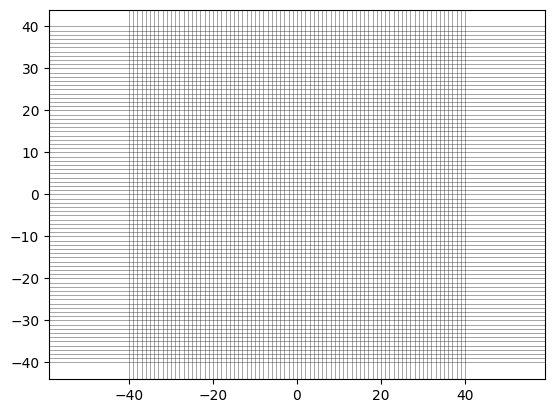

In [2]:
### Example Initialization ###

# make a 64x64x10000 um mesh, wrapped with 8 PML cells. 
# set the transverse spacing to 1 um and the longitudinal spacing to 2 um.

from lightbeam import RectMesh3D

mesh = RectMesh3D(
    xw = 64, # um
    yw = 64, # um
    zw = 10_000, # um
    ds = 1, # um
    dz = 2, # um
    PML = 8 # grid units
)

### some properties and class functions ###

# shape
print(f"Mesh shape: {mesh.shape}")

# shape of transverse grid only
print(f"Transverse grid shape: {mesh.xy.shape}")

# plot the grid lines of the transverse mesh
mesh.xy.plot_mesh()


#### Mesh refinement example

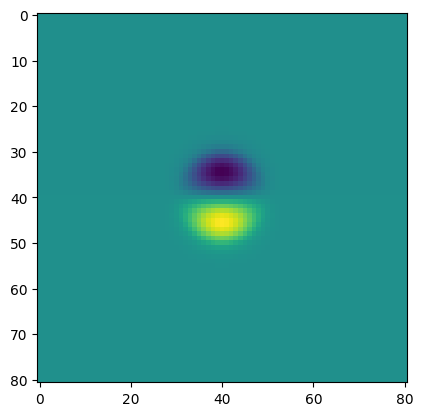

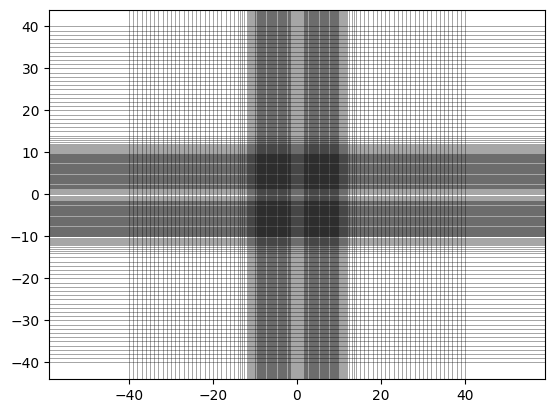

In [3]:
### Mesh refinement example ###

# suppose our field is the LP11 mode, core radius 10 um
# we want to subdivide our field according to this field.

from lightbeam import lpfield
from lightbeam import normalize
import matplotlib.pyplot as plt
import numpy as np

# initial setup to generate the LP11 field

field = normalize(lpfield(
    mesh.xg, mesh.yg, # x, y grids
    1, 1, # mode l and m
    a = 10, # rcore, um 
    wl0 = 1, # wavelength, um
    ncore = 1.5,
    nclad = 1.495
))
plt.imshow(np.real(field))
plt.show()

# I broke this somehow, oops
ref_val = 1e-3  # lower this parameter to increase subdivisions. note that by default the code only allows 
                # for 6 subdivisions so that the minimum grid subdivision will be ds/2^6. This can be \
                # altered under the parameter RectMesh2D.max_iters.

mesh.xy.refine_base(field,ref_val)
mesh.xy.plot_mesh()

## 2. Optics

Since there is no GUI, implementing waveguide geometries will be more cumbersome than something like a CAD environment. Lightbeam provides a skeleton structure for users to define their own waveguide geometries, as well as some pre-defined classes for certain types of photonic lanterns.

### Class types

#### OpticPrim

The base class of all optics is OpticPrim, which contains the basic framework for describing any homogeneous (i.e. only one refractive index) optical structure. Any custom-defined class for homogeneous optical structures should inherit from this class, and requires the definition of two functions: 

1. <strong>self._bbox(z)</strong>: a function that computes the 2D bounding box (xmin,xmax,ymin,ymax) of the optical structure at some given z coordinate.
2. <strong>self._contains(x,y,z)</strong>: a boolean function that determines whether the point (x,y,z) is in the optical structure. This function <strong> must be vectorized</strong>.

Of course the <strong>\__init__()</strong> function will also have to be defined. 

An example OpticPrim-derived class, called __ScaledCyl__, has already been defined. This class can be used to describe any "cylinder" whose cross-sectional diameter and central offset change along the z direction (cylinder caps are assumed to be normal to z).  

#### OpticSys

The next level of complexity is the OpticSys class, which inherits from the OpticPrim class but is really a collection of OpticPrim objects. This class is used to model non-homogeneous optical structures (i.e. anything of interest). Initialization is simple. The required initialization arguments are

<strong>\__init__</strong>

1. __elmnts__: a list of OpticPrim objects composing the optical system. In terms of refractive index, objects later in the list "overwrite" earlier objects.
2. __nb__: the background refractive index in which the optical system is immersed in. Note that this should be similar to to refractive index of the objects in elmnts, to maintain the weakly-guiding approximation which all beam propagation algorithims are based on. For step-index fiber simulation, __nb__ is set to the cladding index (so the cladding is essentially infinite). For photonic lantern simulations, __nb__ is set to the jacket index.

While OpticSys is in principle able to model any waveguide structure, for convenience you may wish to define custom classes derived from OpticSys for specific types of waveguides. This has already been done for several photonic lantern geometries, which you can see in __optics.py__.

#### Code examples

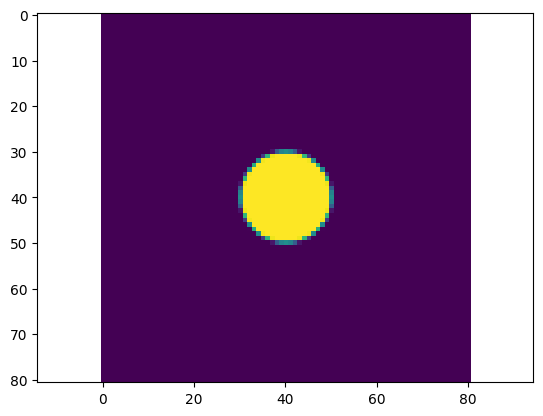

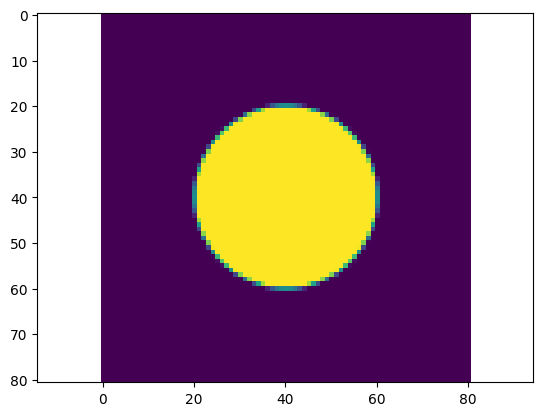

In [4]:
### Let's look at primitives first.### 
# We'll use the ScaledCyl as an example, though not all primitives need to be defined in exactly the same way.
# Note that ScaledCyl also requires us to give it a RectMesh2D object on which to compute refractive index distributions.

mesh.xy.reinit(mesh.xw,mesh.yw)                            # reset the mesh to base, uniform grid. this func specifically will reset 
mesh.xy.update(mesh.xy.rfacxa,mesh.xy.rfacya)    # the grid refinement factors, rfacxa and rfacya

from lightbeam import optics

# initialization params #

xy = [0,0] # where the center of the cylinder is located at z=0.
r = 10 # make the initial radius 10 um
z_ex = 1000 # make the cylinder 1000 um long
n = 1.5 # set the refractive index to 1.5
nb = 1.49 # set the background index to 1.45
final_scale = 2 # set the final cross-sectional scale to 2, so the cylinder grows by a factor of 2

# instantiation #

cyl = optics.ScaledCyl(xy,r,z_ex,n,nb,final_scale=final_scale)
cyl.set_sampling(mesh.xy)# pass in the mesh

out = np.zeros(mesh.xy.shape)

# show structure at z=0
# note that this function computes (refractive index)^2, since that is what's used in the beam prop algorithm.
cyl.set_IORsq(out,0)
plt.imshow(out,vmax=n*n,vmin=nb*nb)
plt.axis('equal')
plt.show()

# show structure at z=1000
cyl.set_IORsq(out,1000)
plt.imshow(out,vmax=n*n,vmin=nb*nb)
plt.axis('equal')
plt.show()

#### Constructing a photonic lantern

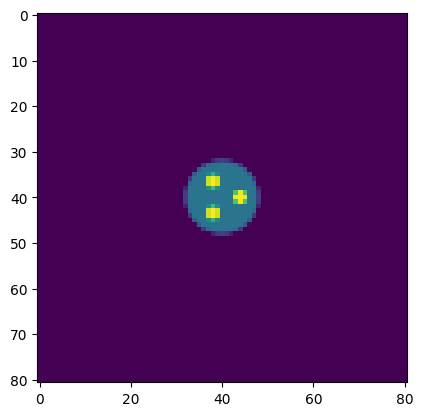

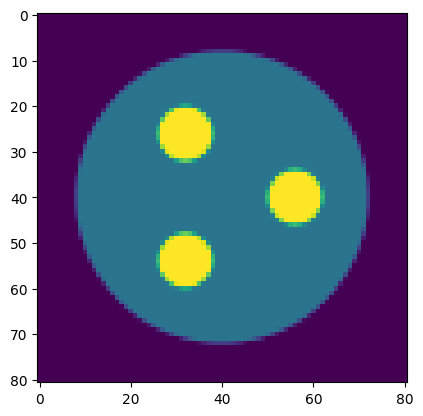

In [7]:
### Constructing a 3 port lantern ###

core_offset = 4 # offset of cores from origin
ncore = 1.4504 + 0.0088 # lantern core refractive index
nclad = 1.4504 # cladding index
njack = 1.4504 - 5.5e-3 # jacket index
rclad = 8
rcore = 1.5
final_scale = 4 # tapering factor of lantern
z_ex = 10000

lant = optics.make_lant3big(core_offset, rcore, rclad, 0, mesh.zw, (ncore, nclad, njack), final_scale=4)
lant.set_sampling(mesh.xy) # OpticSys objects have a function that can send a RectMesh2D object to all contianed primitives,
                            # in order to set the sampling.
out = np.zeros(mesh.xy.shape)

lant.set_IORsq(out,0)
plt.imshow(out,vmin=njack*njack,vmax=ncore*ncore)
plt.show()

lant.set_IORsq(out,10000)
plt.imshow(out,vmin=njack*njack,vmax=ncore*ncore)
plt.show()

(81, 81) (19, 19) (19, 19)
(81, 81) (6, 6) (6, 6)
(81, 81) (6, 6) (6, 6)
(81, 81) (6, 6) (6, 6)


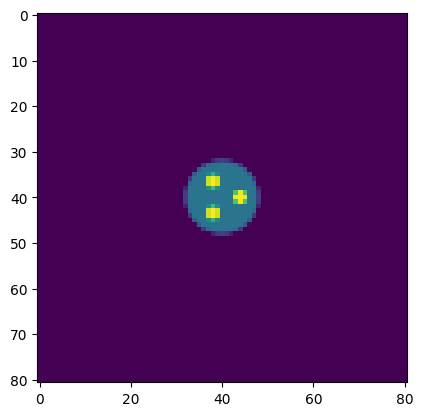

In [10]:
lant.show_cross_section(0)

## 3. Propagation

Beam propagation is handled by the __Prop3D__ class. The technique used to simulate propagation belongs to a class of algorithms that all fall under the umbrella term "finite-differences beam propagation method", or FD-BPM. The particular variant used here follows [1], and works on an adaptive mesh. To initialize a __Prop3D__ object, we need to pass in four things:

<strong>\__init__</strong>
1. __wl0__: the propagation wavelength (remember to keep your units consistent). 
2. __mesh__: the __RectMesh3D__ object defining the simulation space sampling.
3. __optical_system__: the __OpticalSys__ object defining the waveguide geometry which you want to simulate.
3. __n0__: the effective index of propagation for light moving through the waveguide. Physically, this index should be between the highest and lowest indices in the waveguide, which means that setting this to something like a cladding index (recalling we are in the weakly guiding regime) is usually okay. 

To actually start the beam propagation, run the function __Prop3D.prop2end()__, which takes in a launch field and returns the propagated field at the end of the waveguide. Below are the arguments. <br>

<strong>prop2end</strong> <br>

1. __u__: 2D complex array defining the launch field. If the shape of this array does not match the shape of the transverse grid of the simulation zone, the field will be resampled on the grid. In terms of normalization, the power of this field should equal $ \sum_{ij} u^*_{ij}u_{ij} $. Alternatively, you can pass in a function of the form f(x,y) with the same normalization. This latter option is more accurate when using adaptive mesh refinement.

(Optional)
2. __xyslice__,__zslice__: (deprecated) these parameters are arrays of indices which can be used to define a subsection of the field data to save, useful if you want to get cross-sectional images of the electric field as it traverses the waveguide. This feature has not been touched in a while and probably no longer works.
3. __u1_func__: pass in a function of the form f(x,y) that returns an electric field; the propagator will compute the overlap of the electric field and this "monitor" field at each propagation step. Can be useful if you want to track the behavior of the electric field as it moves through the waveguide.
4. __writeto__: (deprecated) a file name string for where to save field data to.
5. __ref_val__: this (float) parameter controls the aggressiveness of the adaptive meshing. Smaller values means more subdivision. At the moment, finding an appropriate value for this parameter requires trial-and-error.
6. __remesh_every__: this (int) parameter controls how many z-steps occur before the adaptive mesh is updated.
7. __dynamic_n0__: when True, the propagator will average the refractive indices in the waveguide system in order to estimate the effective index. Defaults to False.
8. __fplanewidth__: here, you can assign a physical extent to the input field __u__, which will be accounted form when the field is resampled onto the simulation grid. When set to 0, the propagator assumes that the physical extent of the launch field is the same as that of the transverse grid contained in the __mesh__ object (__not__ including PML).

Returns

1. __u__: propagated electric field, sampled on the last non-uniform mesh (this __includes__ the PML zone) used by the propagator. Note that the returned field will be in a different normalization scheme than the input field, to account for the adaptive mesh. The field will be normalized such that the field power equals $ \sum_{ij} w_{ij} u^*_{ij}u_{ij} $, where $w_{ij}$ is the area of the grid cell at index [i,j]. Access this weighting factor through __RectMesh2D.get_weights()__.
2. __u0__: similar to above, but sampled on the __base__ uniform mesh 

A similar propagator, __prop2end_uniform__, is available to handle beam propagation on a fixed, uniform grid.

#### Code example

input field: 


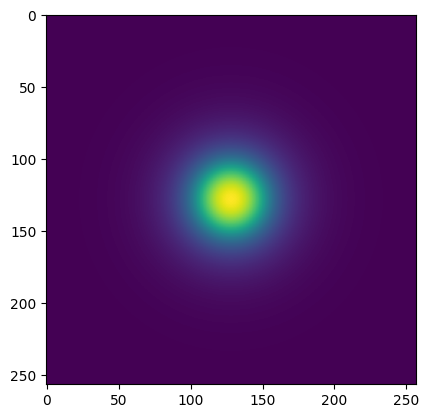

input power:  0.9999999999999998
[-16.    -15.875 -15.75  -15.625 -15.5   -15.375 -15.25  -15.125 -15.
 -14.875 -14.75  -14.625 -14.5   -14.375 -14.25  -14.125 -14.    -13.875
 -13.75  -13.625 -13.5   -13.375 -13.25  -13.125 -13.    -12.875 -12.75
 -12.625 -12.5   -12.375 -12.25  -12.125 -12.    -11.875 -11.75  -11.625
 -11.5   -11.375 -11.25  -11.125 -11.    -10.875 -10.75  -10.625 -10.5
 -10.375 -10.25  -10.125 -10.     -9.875  -9.75   -9.625  -9.5    -9.375
  -9.25   -9.125  -9.     -8.875  -8.75   -8.625  -8.5    -8.375  -8.25
  -8.125  -8.     -7.875  -7.75   -7.625  -7.5    -7.375  -7.25   -7.125
  -7.     -6.875  -6.75   -6.625  -6.5    -6.375  -6.25   -6.125  -6.
  -5.875  -5.75   -5.625  -5.5    -5.375  -5.25   -5.125  -5.     -4.875
  -4.75   -4.625  -4.5    -4.375  -4.25   -4.125  -4.     -3.875  -3.75
  -3.625  -3.5    -3.375  -3.25   -3.125  -3.     -2.875  -2.75   -2.625
  -2.5    -2.375  -2.25   -2.125  -2.     -1.875  -1.75   -1.625  -1.5
  -1.375  -1.25   -1.125  -1.  

  0%|          | 0/2501 [00:00<?, ?it/s]

final total power 0.9991129946940454
output field: 


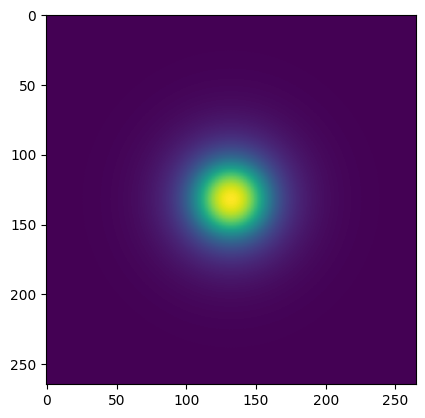

In [11]:
### Code example ###

import matplotlib.pyplot as plt
import numpy as np
from lightbeam import optics
from lightbeam import normalize

# first off, note that running Lightbeam code in a Jupyter notebook is probably not the greatest idea. A better practice would
# be to write dedicated Python scripts to execute the propagation. As an example, see run_bpm_example.py and config_example.py
# for one way to do this scripting.

# nevertheless, we will show some examples of how to run Lightbeam within this notebook environment, as well.

# below is a simple example where we propagate the LP01 mode with some tilt applied through a single-mode fiber.
# note that in this simple example, I find no noticeable improvement from adaptive meshing, so we won't use it.
# more complicated waveguide geometries such as photonic lanterns do benefit from adaptive meshing, see section 5.

wl = 1.55 #um, wavelength

## Mesh ##

num_PML = 4
mesh = RectMesh3D(xw = 32,yw = 32, zw = 10000, ds = 0.125, dz = 4, PML = num_PML)
xg, yg = mesh.xg[num_PML:-num_PML,num_PML:-num_PML],mesh.yg[num_PML:-num_PML,num_PML:-num_PML]


## Optic (SMF) ##

rcore = 3 #um

ncore = 1.4504 + 0.0088
nclad = 1.4504

fiber_core = optics.ScaledCyl([0,0],rcore,mesh.zw,ncore,nclad)
SMF = optics.OpticSys([fiber_core],nclad)

## Launch field ## 

u0 = normalize(lpfield(xg,yg,0,1,rcore,wl,ncore,nclad))

print("input field: ")
plt.imshow(np.abs(u0))
plt.show()

## propagation ##

from lightbeam import Prop3D

prop = Prop3D(wl,mesh,SMF,nclad)

u0 = prop.prop2end(u0)

print("output field: ")
plt.imshow(np.abs(u0))

plt.show()

## 4. Extra functionality

Here we go over some extra functions you may find useful in conjunction with the main propagation code in Lightbeam.

### Zernike Polynomials

The file __zernike.py__ contains functions for generating Zernike aberrations. To generate a Zernike field, you can use __Zj_cart()__.

### LP modes

The file __LPmodes.py__ contains functions for generating the LP modes of a circularly symmetric step-index fiber. Fields can be generated using the function __lpfield()__.

### Turbulence

A simple auto-regressive and Fourier-based model for Kolmogorov turbulence can be found in __screen.py__. The model is based on the implementation from [3].

### Misc utility functions

Functions for computing overlap integrals and for normalizing fields can be found in __misc.py__.

## 5. More on adaptive meshing

### Disclaimers

This package's implementation of adaptive mesh refinement (AMR) is __not__ a switch that can be flicked to make beam propagation faster and more accurate. Below are some things to keep in mind.

1. For simple geometries like step-index fibers, AMR provides little to no benefit.
2. While propagation through each z-step is theoretically accurate to 4th order, errors will arise due to interpolation of the electric field, which must be done whenever the adaptive mesh is modified.
3. The AMR algorithm is more much more complex, offsetting potential savings in computation time.
4. Finding the best adaptive meshing parameters for your given application needs to be done empirically, and will take some effort.

Despite this, if properly tuned, AMR can indeed provide some savings to computation time.

### Tuning AMR

Getting AMR to work well is more an art than a science. The important parameters to tweak are as follows:

1. __RectMesh2D.dx__ (and __dy__): the base grid resolution. Often times, I find that it is good to not let this parameter get too coarse (it should probably be smaller than the propagation wavelength.)
2. __RectMesh2D.max_iters__: the maximum amount of halvings that a base grid cell can undergo. Values of 4-7 typically work well.
3. __ref_val__: a reference value (arg of __prop2end__) that controls how aggressively cells are split. See also: <strong> RectMesh2D._compute_refinement_factor() </strong>. Lower values correspond to a more aggressive splitting. For the default mesh refinement scheme, "good" values for this parameter will like be on the order of 10<sup>-4</sup>.
4. __remesh_every__: (arg of __prop2end__) the number of z-steps that pass before the adaptive mesh is recomputed.
5. (Optional) <strong> RectMesh2D._compute_refinement_factor(). </strong>: the function that determines which grid cells should be split. The default scheme generally works well, but will likely not be globally optimal.


### An example use case

Below are results from the simulation of a tilted LP01 mode field propagating through a 3-port lantern. This lantern has an initial entrance diameter of 8 um and a taper factor of 4 (so that the exit geometry is simply the entrance geometry, but scaled up by a factor of 4), and the output SMF cores have a diameter of 4.4 um. The propagation wavelength is 1 um. Plotted in black is simulation accuracy against computation time (the points from left to right corresponds to grid resolutions of 2, 1, 1/2, 1/4, 1/8, and 1/16 um, respectively.) Plotted in blue is with AMR turned on, setting base resolution __dx__ = __dy__ = 0.25 um, __ref_val__ = 2e-4, __max_iters__ = 5, and __remesh_every__ = 50.

![](amr_comp.png)

*Notes* <br>

Plotting an absolute error requires knowing the "true" output port powers for this lantern and launch field. For practicality, this was assumed to be the output of the beam propagator, setting a uniform grid resolution of 1/32 um. "Error" of a given lantern response is quantified as the distance between the vector composed of the lantern port powers and the vector of "true" port powers. The code used to generate this plot is based off __convergence.py__.

# References 

[1] Jun Shibayama, Kenji Matsubara, Minoru Sekiguchi, Junji Yamauchi, and Hisamatsu Nakano, "Efficient Nonuniform Schemes for Paraxial and Wide-Angle Finite-Difference Beam Propagation Methods," J. Lightwave Technol. 17, 677- (1999) <br>

[2] Ginés Lifante Pedrola, "Beam Propagation Method for Design of Optical Waveguide Devices," Wiley (2015) <br>

[3] Srikar Srinath, Lisa A. Poyneer, Alexander R. Rudy, and S. Mark Ammons, "Computationally efficient autoregressive method for generating phase screens with frozen flow and turbulence in optical simulations," Opt. Express 23, 33335-33349 (2015)